# Algoritmos de optimización

Nombre: Carlos Cesar Meza Montalvo

## Reto 3

Mejorar la implementación de colonia de hormigas implementada en clase sobre el TSP mediante una elección de nodo que tenga en consideración una función de probabilidad que depende de las feromonas.

### Optimización por colonia de hormigas (Ant Colony Optimization, ACO)

Es una técnica basada en la observación del comportamiento colectivo de las hormigas para resolver problemas de optimización. Esta técnica se inspira en la forma en que las colonias de hormigas encuentran y transportan comida de vuelta a su hormiguero, adaptándose a cambios en su entorno y encontrando siempre el mejor camino.
Funcionamiento de ACO
1.	Feromonas y Comunicación:
o	Las hormigas emiten feromonas mientras se desplazan, dejando un rastro químico que otras hormigas pueden seguir.
o	Este rastro se refuerza con la actividad de otras hormigas y se debilita con el tiempo.
o	Cuanto más fuerte es el rastro, mayor es la probabilidad de que otras hormigas lo sigan.
2.	Comportamiento Aleatorio y Adaptabilidad:
o	Aunque las hormigas siguen rastros de feromonas, también exploran aleatoriamente nuevas rutas.
o	Este comportamiento aleatorio permite la exploración de nuevas opciones y la adaptación a cambios en el entorno.
o	Si una nueva ruta resulta ser más corta o más eficiente, se reforzará rápidamente debido a la mayor frecuencia de uso, desplazando al rastro anterior.
3.	Optimización Colectiva:
o	El proceso continuo de exploración y refuerzo de rutas permite a la colonia, como un todo, encontrar y mantener el mejor camino disponible.
o	A través de la colaboración y la adaptación, las hormigas pueden responder dinámicamente a cambios y encontrar soluciones óptimas a problemas complejos.

La técnica de ACO demuestra cómo el estudio de comportamientos naturales puede inspirar soluciones innovadoras y eficientes para problemas complejos en diversos campos.
Para mejorar la implementación del algoritmo genético (GA) para la resolución del problema del viajante de comercio (TSP) con la optimización por colonia de hormigas (ACO), podemos combinar ambos enfoques. En esta versión, ACO se utiliza para mejorar la generación inicial de la población en el algoritmo genético, aumentando la probabilidad de encontrar mejores soluciones desde el principio.



Para mejorar la implementación del algoritmo genético (GA) para la resolución del problema del viajante de comercio (TSP) con la optimización por colonia de hormigas (ACO), podemos combinar ambos enfoques. En esta versión, ACO se utiliza para mejorar la generación inicial de la población en el algoritmo genético, aumentando la probabilidad de encontrar mejores soluciones desde el principio.



Mejor camino encontrado: [5, 1, 0, 3, 4, 9, 2, 8, 6, 7, None]
Costo mejor camino: 32


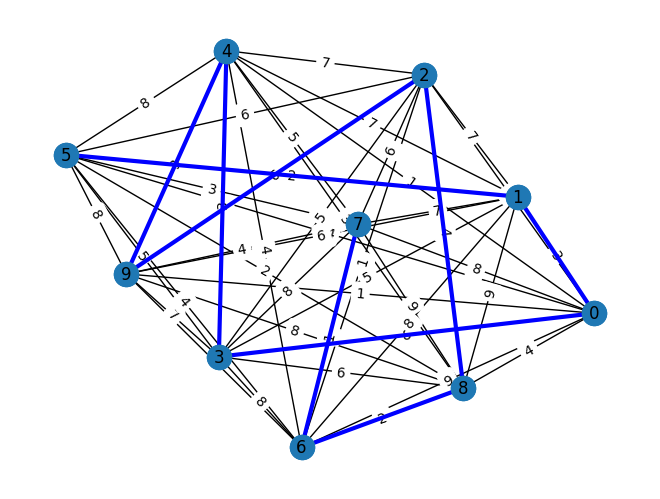

In [24]:
import numpy as np
import random
import matplotlib.pyplot as plt
import networkx as nx

# Definir el grafo TSP
num_nodos = 10
G = nx.complete_graph(num_nodos)
for (u, v) in G.edges():
    G.edges[u, v]['weight'] = np.random.randint(1, 10)

# Función para calcular la distancia total del recorrido
def calcular_distancia(graph, camino):
    distancia = 0
    for i in range(len(camino) - 1):
        if camino[i] is not None and camino[i+1] is not None: # Check if nodes in path are valid
            distancia += graph[camino[i]][camino[i+1]]['weight']
    return distancia

# Algoritmo ACO para generar soluciones iniciales
def ACO(graph, num_hormigas, num_iteraciones, evaporacion, alfa, beta):
    num_nodos = len(graph)
    feromonas = np.ones((num_nodos, num_nodos))
    visibilidad = 1.0 / (np.array(nx.adjacency_matrix(graph).todense(), dtype=float) + 1e-10)

    mejores_caminos = []

    for _ in range(num_iteraciones):
        hormigas = []
        for _ in range(num_hormigas):
            nodo_inicial = np.random.randint(num_nodos)
            camino = [nodo_inicial]
            costo = 0
            while len(camino) < num_nodos:
                nodo_actual = camino[-1]
                probabilidades = []
                for nodo in range(num_nodos):
                    if nodo not in camino:
                        prob = (feromonas[nodo_actual][nodo] ** alfa) * (visibilidad[nodo_actual][nodo] ** beta)
                        probabilidades.append(prob)
                    else:
                        probabilidades.append(0)
                probabilidades = np.array(probabilidades)
                probabilidades /= probabilidades.sum()
                siguiente_nodo = np.random.choice(num_nodos, p=probabilidades)
                camino.append(siguiente_nodo)
                costo += graph[nodo_actual][siguiente_nodo]['weight']
            costo += graph[camino[-1]][camino[0]]['weight']
            camino.append(camino[0])
            hormigas.append((camino, costo))
            if len(mejores_caminos) < num_hormigas:
                mejores_caminos.append(camino)
            else:
                peor_camino = max(mejores_caminos, key=lambda x: calcular_distancia(graph, x))
                if costo < calcular_distancia(graph, peor_camino):
                    mejores_caminos.remove(peor_camino)
                    mejores_caminos.append(camino)

        for camino, costo in hormigas:
            for i in range(num_nodos):
                feromonas[camino[i]][camino[i+1]] += 1.0 / costo

    return mejores_caminos

# Parámetros de ACO
num_hormigas = 10
num_iteraciones_aco = 50
evaporacion_feromona = 0.5
influencia_feromona = 1.0
influencia_visibilidad = 2.0

# Generar soluciones iniciales con ACO
poblacion_inicial = ACO(G, num_hormigas, num_iteraciones_aco, evaporacion_feromona, influencia_feromona, influencia_visibilidad)

# Funciones del Algoritmo Genético (GA)
def seleccionar_padres(poblacion, fitness):
    padres = random.choices(poblacion, weights=fitness, k=2)
    return padres

def cruzamiento(padre1, padre2):
    size = len(padre1)
    start, end = sorted(random.sample(range(size), 2))
    hijo = [None] * size
    hijo[start:end] = padre1[start:end]
    puntero = 0
    for gen in padre2:
        if gen not in hijo:
            while hijo[puntero] is not None:
                puntero += 1
            hijo[puntero] = gen
    # Ensure no None values remain in the child
    for i in range(size):
        if hijo[i] is None:
            for gen in padre2:
                if gen not in hijo:
                    hijo[i] = gen
                    break
    return hijo

def mutacion(caminos, tasa_mutacion):
    for camino in caminos:
        if random.random() < tasa_mutacion:
            # Ensure valid indices for swapping
            while True:
                i, j = random.sample(range(1, len(camino) - 1), 2)
                if camino[i] is not None and camino[j] is not None:
                    break
            camino[i], camino[j] = camino[j], camino[i]
    return caminos

def algoritmo_genetico(graph, poblacion_inicial, num_generaciones, tasa_mutacion):
    poblacion = poblacion_inicial
    for _ in range(num_generaciones):
        fitness = [1 / calcular_distancia(graph, camino) for camino in poblacion]
        nueva_poblacion = []
        for _ in range(len(poblacion) // 2):
            padres = seleccionar_padres(poblacion, fitness)
            hijos = cruzamiento(padres[0], padres[1]), cruzamiento(padres[1], padres[0])
            nueva_poblacion.extend(hijos)
        poblacion = mutacion(nueva_poblacion, tasa_mutacion)
    mejor_camino = min(poblacion, key=lambda x: calcular_distancia(graph, x))
    return mejor_camino, calcular_distancia(graph, mejor_camino)

# Parámetros del GA
num_generaciones = 150
tasa_mutacion = 0.1

# Ejecutar el algoritmo combinado ACO-GA
mejor_camino, mejor_costo = algoritmo_genetico(G, poblacion_inicial, num_generaciones, tasa_mutacion)

# Visualización del resultado
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)

print("Mejor camino encontrado:", mejor_camino)
print("Costo mejor camino:", mejor_costo)

# Mostrar el camino más óptimo

valid_path = [node for node in mejor_camino if node is not None]
edge_list = [(valid_path[i], valid_path[i + 1]) for i in range(len(valid_path) - 1)]

path_graph = nx.Graph()
path_graph.add_edges_from(edge_list)
nx.draw(path_graph, pos, edge_color='b', width=3.0)

plt.show()